## We are provided with the NYC Taxi Trip Dataset. This dataset contains information about the taxi trips that took place in different parts of New York City and how much time did that trip take to complete.

## In this project we have the following tasks as follows:-
### 1. Build a K-Nearest neighbours model for the given dataset and find the best value of K. 
### 2. Build a Linear model for the given dataset with regularisation. 
### 3. Build a Random Forest model for the given dataset. 
### 4. Build a Gradient Boosting model for the given dataset. 
### 5. Combine all the models above using the averaging technique to generate the final predictions.

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import geopy.distance

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('nyc_taxi_trip_duration_dataset.csv')

## Performing Exploratory Data Analysis and Feature Engineering

## Dataset Variables
### Dataset Variables are as follows :
#### ● vendor_id - code indicating provider associated with the trip record
#### ● id - unique identifier for each trip
#### ● pickup_datetime - date and time when the trip started
#### ● dropoff_datetime - date and time when the trip ended
#### ● passenger_count - number of passengers present during the trip
#### ● pickup_longitude - the longitude where the trip was started
#### ● pickup_latitude - the latitude where the trip was started
#### ● dropoff_longitude - the longitude where the trip was ended
#### ● dropoff_latitude - the latitude where the trip was ended
#### ● store_and_fwd_flag - The flag indicates that whether the connection during the trip with vehicle and vendor was lost due to any technical issue or not
#### ● trip_duration - duration of trip in seconds

In [3]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [4]:
data.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
729317,id3905982,2,2016-05-21 13:29:38,2016-05-21 13:34:34,2,-73.965919,40.789780,-73.952637,40.789181,N,296
729318,id0102861,1,2016-02-22 00:43:11,2016-02-22 00:48:26,1,-73.996666,40.737434,-74.001320,40.731911,N,315
729319,id0439699,1,2016-04-15 18:56:48,2016-04-15 19:08:01,1,-73.997849,40.761696,-74.001488,40.741207,N,673
729320,id2078912,1,2016-06-19 09:50:47,2016-06-19 09:58:14,1,-74.006706,40.708244,-74.013550,40.713814,N,447
729321,id1053441,2,2016-01-01 17:24:16,2016-01-01 17:44:40,4,-74.003342,40.743839,-73.945847,40.712841,N,1224


In [5]:
data.shape

(729322, 11)

In [6]:
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

#### We have no missing values in this dataset.

In [7]:
data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [8]:
# Checking for any duplicate records in the dataset

data.duplicated().sum()

0

So, we have 0 duplicate records in the dataset which is good.

In [9]:
# Checking unique values in all columns

data.nunique()

id                    729322
vendor_id                  2
pickup_datetime       709359
dropoff_datetime      709308
passenger_count            9
pickup_longitude       19729
pickup_latitude        39776
dropoff_longitude      27892
dropoff_latitude       53579
store_and_fwd_flag         2
trip_duration           6296
dtype: int64

Now, as per the dataset we have different types of variables which we will explore further each of them individually. But, we don't require the 'id' variable as it has 729322 unique values which we don't need for our model.

'trip_duration' is the target variable and the values are continuous and hence this problem is a Regression Problem.

In [10]:
data['store_and_fwd_flag'].value_counts()

N    725282
Y      4040
Name: store_and_fwd_flag, dtype: int64

The store_and_fwd_flag variable contains only two values i.e. Y and N.
We can convert these values into numeric datatype by using Label Encoder.

In [11]:
encoder = LabelEncoder()

# Encoding column store_and_fwd_flag
data['store_and_fwd_flag_label'] = encoder.fit_transform(data['store_and_fwd_flag'])
data['store_and_fwd_flag_label'] = encoder.fit_transform(data['store_and_fwd_flag'])

In [12]:
# Converting pickup and dropoff from object to datetime

data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [13]:
# Using datetime to create more new columns - day_number, pickup_hour, day_name

data['week_number'] = data.pickup_datetime.dt.weekday
data['pickup_hour'] = data.pickup_datetime.dt.hour
data['day'] = data.pickup_datetime.dt.day

Text(0, 0.5, 'Total No. of pickups')

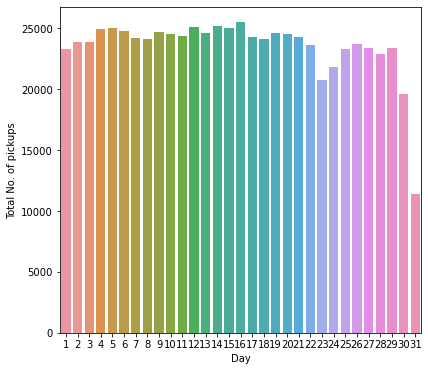

In [14]:
# Plotting the pickup day wrt total no. of pickups

plt.figure(figsize = (22,6))
plt.subplot(131)
sns.countplot(data['day'])
plt.xlabel('Day')
plt.ylabel('Total No. of pickups')

Text(0, 0.5, 'Total no. of pickups')

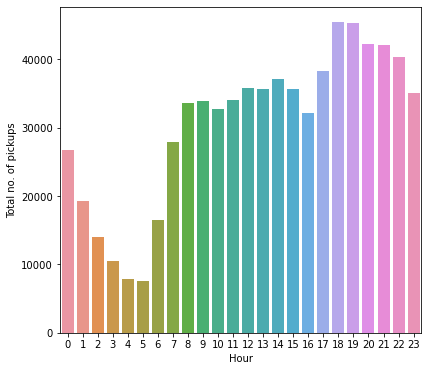

In [15]:
# Plotting the hour wrt the total no. of pickups

plt.figure(figsize = (22,6))
plt.subplot(132)
sns.countplot(data['pickup_hour'])
plt.xlabel('Hour')
plt.ylabel('Total no. of pickups')

Text(0, 0.5, 'Total no. of pickups')

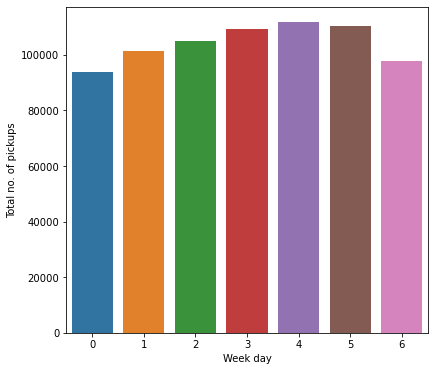

In [16]:
# plotting the week day wrt the total no. of pickups

plt.figure(figsize = (22,6))
plt.subplot(133)
sns.countplot(data['week_number'])
plt.xlabel('Week day')
plt.ylabel('Total no. of pickups')

### Insights:-

    1. On Thursday(4), trip is on peak.
    
    2. Trip is on peak between hour 17-22 i.e. in evenings of the day.
    
    3. The no. of trip is high in the first three weeks.

In [17]:
data['drop_day'] = data.dropoff_datetime.dt.day
data['drop_hour'] = data.dropoff_datetime.dt.hour
data['drop_week'] = data.dropoff_datetime.dt.weekday

In [18]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,store_and_fwd_flag_label,week_number,pickup_hour,day,drop_day,drop_hour,drop_week
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400,0,0,16,29,29,16,0
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,0,4,23,11,11,23,4
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,0,6,17,21,21,18,6
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,0,1,9,5,5,10,1
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848,0,2,6,17,17,6,2


In [19]:
# Getting distance calculated with the help of geopy

def calc_dist(data):
    pickup = (data['pickup_latitude'], data['pickup_longitude'])
    dropoff = (data['dropoff_latitude'], data['dropoff_longitude'])
    return geopy.distance.distance(pickup, dropoff).km

In [20]:
# Adding a new distance column

data['distance'] = data.apply(lambda x: calc_dist(x), axis=1)

In [21]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,store_and_fwd_flag_label,week_number,pickup_hour,day,drop_day,drop_hour,drop_week,distance
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400,0,0,16,29,29,16,0,1.199770
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,0,4,23,11,11,23,4,4.123945
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,0,6,17,21,21,18,6,7.250436
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,0,1,9,5,5,10,1,2.358287
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848,0,2,6,17,17,6,2,4.328155


In [22]:
data['distance'].value_counts()

0.000000    2901
0.650138       2
0.000424       2
2.000050       1
0.857289       1
            ... 
4.937193       1
2.132841       1
2.462624       1
0.904627       1
7.361812       1
Name: distance, Length: 726420, dtype: int64

As per the dataset, there are 2901 records with distance travelled as 0.

In [23]:
data['passenger_count'].value_counts()

1    517415
2    105097
5     38926
3     29692
6     24107
4     14050
0        33
7         1
9         1
Name: passenger_count, dtype: int64

We have extremely low values for the passenger count above 6 and 0. We will remove these records.

In [24]:
# Considering only upto 6 passengers count

data = data[data['passenger_count'] <= 6]
data = data[data['passenger_count'] > 0]

In [25]:
# Again checking the passenger count

data['passenger_count'].value_counts()

1    517415
2    105097
5     38926
3     29692
6     24107
4     14050
Name: passenger_count, dtype: int64

In [26]:
# Exploring the target variable - trip_duration
data['trip_duration'].describe()/3600

count    202.579722
mean       0.264515
std        1.073531
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

The max value in trip duration is 538 which is an outlier. We have to perform log transform to make more accurate predictions.

In [27]:
#trip duration in hours
data['trip_duration_hour'] = data['trip_duration'].apply(lambda x: x/3600)

In [28]:
#Removing outliers from the dataset such that the value does not exceeds a day or 24 hours.

data = data[data['trip_duration_hour'] <= 24]

In [29]:
data['trip_duration_hour'].min()

0.0002777777777777778

In [30]:
data['trip_duration_hour'].max()

23.9975

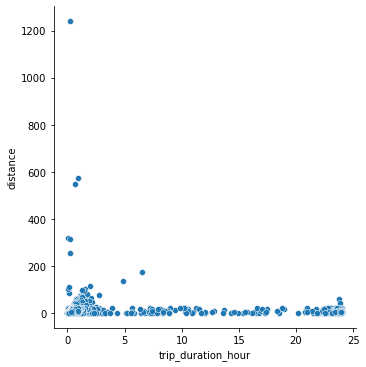

In [31]:
sns.relplot(y = data['distance'], x = data['trip_duration_hour'])

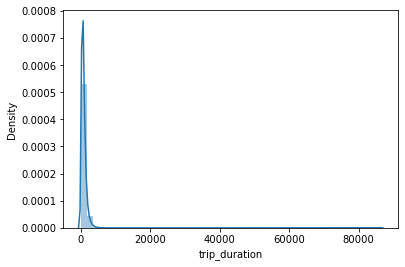

In [32]:
sns.distplot(data['trip_duration'])
plt.show()

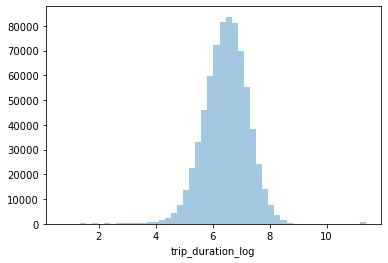

In [33]:
# Performing log transform on trip duration in seconds

data['trip_duration_log'] = np.log(data['trip_duration'].values + 1)
sns.distplot(data['trip_duration_log'], kde = False)
plt.show()

We are done with the Feature Exploration part, we can remove the unwanted columns from the dataset and even the outliers present.

In [34]:
df = data.drop(columns = ['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_latitude', 'pickup_longitude', 
                         'dropoff_latitude', 'dropoff_longitude', 'store_and_fwd_flag', 'trip_duration', 'trip_duration_hour'])

In [35]:
x = df.drop('trip_duration_log', axis=1)
y = df['trip_duration_log']

In [36]:
# Scaling the data

scaler = MinMaxScaler()
x_scale = scaler.fit_transform(x)

x = pd.DataFrame(x_scale, columns = x.columns)

As we have to predict discrete value and our target variable- trip_duration is continuous, we can say that this is a Regression Problem.

#### Evaluation Metric selected :- R-squared 

## Building K Nearest Neighbor Model and finding the best value of k

In [37]:
train_x1, test_x1, train_y1, test_y1 = train_test_split(x, y, test_size = 0.25, random_state = 42)

In [38]:
# Elbow curve to determine the best value of k
def elbow(k):
    test = []
    
    for i in k:
        regr = KNeighborsRegressor(n_jobs = -1, n_neighbors = i)
        regr.fit(train_x1, train_y1)
        
        temp_pred = regr.predict(test_x1)
        temp_error = sqrt(mean_squared_error(temp_pred, test_y1)) # Using RMSE for getting elbow curve
        test.append(temp_error)
        
    return test

In [39]:
k = range(2, 6)

In [40]:
test1 = elbow(k)

Text(0.5, 1.0, 'Elbow curve for test')

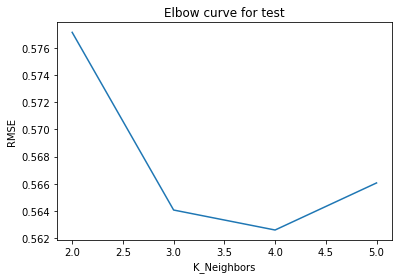

In [41]:
# Plotting curve

plt.plot(k, test1)
plt.xlabel('K_Neighbors')
plt.ylabel('RMSE')
plt.title('Elbow curve for test')

As we can look at the elbow curve plot, the lowest error occurs at k=4

In [42]:
knn = KNeighborsRegressor(n_jobs = -1, n_neighbors = 4)
knn.fit(train_x1, train_y1)

KNeighborsRegressor(n_jobs=-1, n_neighbors=4)

In [43]:
# Prediction on test
knn_pred = knn.predict(test_x1)

# Checking R square score
rscore = r2_score(test_y1, knn_pred)
rscore

0.5001540786344896

We got R-square score of KNN Model as - 0.50015

### Building Linear Regression Model with Regularisation.

In [44]:
# Linear Model
linear = LinearRegression()
linear.fit(train_x1, train_y1)

LinearRegression()

In [45]:
pred = linear.predict(test_x1)

# Checking score
lscore = r2_score(test_y1, pred)
lscore

0.36503803944085345

With Linear Regression, we got r-square score as - 0.36503

#### Ridge Regression is a regularised linear regression model, So we use Ridge in this model. 

In [46]:
# Creating Ridge regression model
ridge_regr = Ridge(alpha = 1.0)
ridge_regr.fit(train_x1, train_y1)

Ridge()

In [47]:
# Getting Test score
ridge_pred = ridge_regr.predict(test_x1)

re_score = r2_score(test_y1, ridge_pred)
re_score

0.34729058595313944

### Building Random Forest model for the dataset.

In [48]:
random_for = RandomForestRegressor(random_state = 42)
random_for.fit(train_x1, train_y1)

RandomForestRegressor(random_state=42)

In [49]:
# Getting prediction and score

random_pred = random_for.predict(test_x1)

random_score = r2_score(test_y1, random_pred)
random_score

0.6685600779144829

### Building Gradient Boosting Model for the dataset.

In [50]:
xg_boost = XGBRegressor(random_state = 42, objective = 'reg:squarederror')
xg_boost.fit(train_x1, train_y1)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [51]:
# Getting prediction and score of the model

xg_pred = xg_boost.predict(test_x1)

xg_score = r2_score(test_y1, xg_pred)
xg_score

0.7270941243460809

### Combining all the different models to use averaging technique and generating final prediction.

In [52]:
# Averaging all the prediction from models- ridge, knn, random forest, xg boost regressor and obtaining score.

combine_pred = (xg_pred + random_pred + ridge_pred + knn_pred)/4

combine_score = r2_score(test_y1, combine_pred)
combine_score

0.6644762000679889

The R-square score we get by using averaging technique is:- 0.664476